In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
from scipy.signal import butter, filtfilt, freqz
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from reservoir_computing import ReservoirDS
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

# Load Data

In [3]:
filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
f = h5py.File(filename, 'r')
electrode_info, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = get_sample_interval(f, units='s')
lfp = f['lfp']
T = lfp.shape[1]

# Up and Down States

In [5]:
area_spike_dict = {}
for area in session_info['areas']:
    print(area)
    unit_inds = np.where(unit_info['area'] == area)[0]
    area_spike_dict[area] = np.zeros((len(unit_inds), T))
    for i, ind in enumerate(unit_inds):
        unit_spike_times = spike_times[ind][0, :]
        for t in unit_spike_times:
            area_spike_dict[area][i, int(t/dt)] = 1

vlPFC
FEF
CPB
7b


In [6]:
up_down_dict = get_up_down(area_spike_dict)

# Analyze Single Run

In [ ]:
data_path = "../../__data__/VAR"

# load data if not loaded
window = 0.5
stride = 0.01
PCA_dim = -1

results = load(os.path.join(data_path, f"results_window_{window}_stride_{stride}_PCA_dim_{PCA_dim}"))

## Goodness of Fit

In [ ]:
area = 'vlPFC'

In [ ]:
goodness_of_fit = 0
for i in range(len(results[area]['sigma_norms'])):
    goodness_of_fit += results[area]['sigma_norms'][i]/results[area]['data_sigma_norms'][i]
goodness_of_fit /= len(results[area]['sigma_norms'])
print(f"Goodness of fit (ratio of error covariance norm to data covariance norm): {goodness_of_fit:.5f}")

In [ ]:
print(f"Mean ML estimate of sigma squared: {results[area]['sigma2_ML'].mean():.5f}")
print(f"Mean AIC: {results[area]['AIC'].mean():.5f}")

## Plot

In [52]:
area = 'vlPFC'

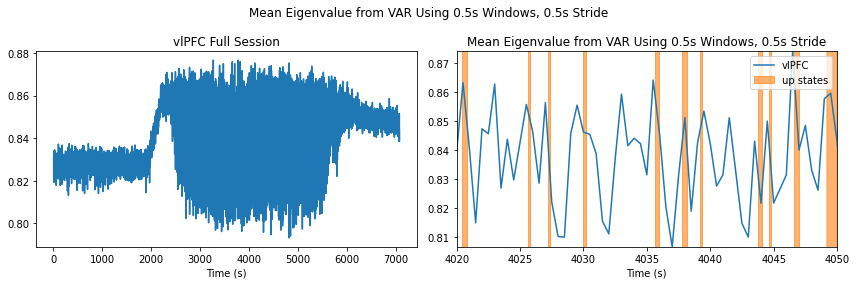

In [53]:
plt.figure(figsize=(12, 4))

start = 20
end = -30
plt.subplot(1, 2, 1)
plt.plot((np.arange(results[area]['eigs'].shape[0])*stride)[start:end], results[area]['eigs'].mean(1)[start:end], label=area, c=f"C{0}")
plt.xlabel("Time (s)")
plt.title(area + " Full Session")
# plt.legend()

def correct_ylim(ax, x, y):   
    # ax: axes object handle
    #  x: data for entire x-axes
    #  y: data for entire y-axes
    # assumption: you have already set the x-limit as desired
    lims = ax.get_xlim()
    i = np.where( (x > lims[0]) &  (x < lims[1]) )[0]
    ax.set_ylim( y[i].min(), y[i].max() ) 

start = 4020 # s
end = 4050 # s
plt.subplot(1, 2, 2)
ax = plt.gca()
x = np.arange(results[area]['eigs'].shape[0])*stride
y = results[area]['eigs'].mean(1)
ax.plot(x, y, label=area)
ax.fill_between(np.arange(len(up_down_dict[area]))*dt, 0, 1, where=up_down_dict[area], color='C1', alpha=0.6, label='up states')
ax.set_xlim([start, end])
correct_ylim(ax, x, y)
ax.autoscale_view()
plt.title(f"Mean Eigenvalue from VAR Using {window}s Windows, {stride}s Stride")
plt.xlabel("Time (s)")
plt.legend()

title_string = f"Mean Eigenvalue from VAR Using {window}s Windows, {stride}s Stride"
if PCA_dim > 0:
    title_string += f" PCA Dim {PCA_dim}"
plt.suptitle(title_string)
plt.tight_layout()
plt.show()

In [54]:
if 'explained_variances' in results[area].keys():
    start = 20
    end = -30
    for i in range(PCA_dim):
        plt.plot((np.arange(results[area]['eigs'].shape[0])*stride)[start:end], results[area]['explained_variances'][start:end, i], label=f'PC{i+1}')
    plt.plot((np.arange(results[area]['eigs'].shape[0])*stride)[start:end], results[area]['explained_variances'].sum(axis=1)[start:end], label='total')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.title("Explained Variance Ratios From PCA")
    plt.show()
else:
    print('No explained variances to plot.')

No explained variances to plot.


# Analyze Multi-Run

In [14]:
data_path = "../../__data__/VAR"
area = 'vlPFC'
stride = 0.01
PCA_dim = -1

windows = [0.15, 0.25, 0.5, 0.75, 1, 2.5]
metrics = {}

metrics['goodness_of_fit'] = np.zeros(len(windows))
metrics['sigma2_ML'] = np.zeros(len(windows))
metrics['AIC'] = np.zeros(len(windows))
metrics['1step_pred_dist'] = np.zeros(len(windows))

for i_w, window in enumerate(windows):
    results = load(os.path.join(data_path, f"results_window_{window}_stride_{stride}_PCA_dim_{PCA_dim}"))
    
    goodness_of_fit = 0
    for i in range(len(results[area]['sigma_norms'])):
        goodness_of_fit += results[area]['sigma_norms'][i]/results[area]['data_sigma_norms'][i]
    goodness_of_fit /= len(results[area]['sigma_norms'])
    metrics['goodness_of_fit'][i_w] = goodness_of_fit
    
    metrics['sigma2_ML'][i_w] = results[area]['sigma2_ML'].mean()
    metrics['AIC'][i_w] = results[area]['AIC'].mean()
    metrics['1step_pred_dist'][i_w] = results[area]['1step_pred_dist'].mean()

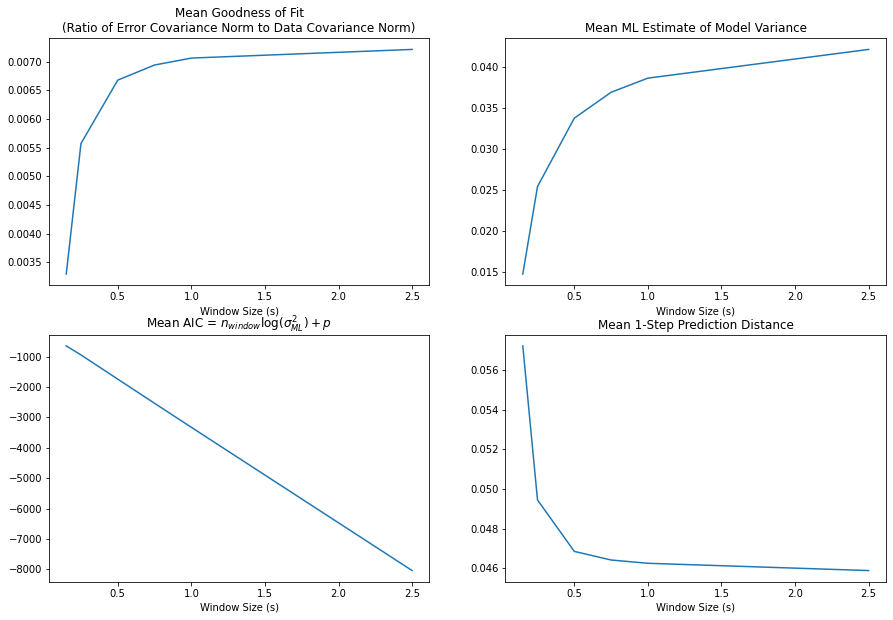

In [15]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(windows, metrics['goodness_of_fit'])
plt.xlabel('Window Size (s)')
plt.title('Mean Goodness of Fit\n(Ratio of Error Covariance Norm to Data Covariance Norm)')

plt.subplot(2, 2, 2)
plt.plot(windows, metrics['sigma2_ML'])
plt.xlabel('Window Size (s)')
plt.title("Mean ML Estimate of Model Variance")

plt.subplot(2, 2, 3)
plt.plot(windows, metrics['AIC'])
plt.xlabel('Window Size (s)')
plt.title(r"Mean AIC = $n_{window}\log(\sigma^2_{ML}) + p$")

plt.subplot(2, 2, 4)
plt.plot(windows, metrics['1step_pred_dist'])
plt.xlabel('Window Size (s)')
plt.title(r"Mean 1-Step Prediction Distance")

plt.show()